# AVISO data assimilation with correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import build_h_matrix, skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error_over_time
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 2 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
time_range = (day1 - day0) * 2
start_date = '2016-06-01' ## starting date
n_waves = '190' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]

In [6]:
ssha_time_mean = SSHA[day0 : day0 + 30].mean(axis = 0)

In [7]:
SSHA = SSHA - SSHA[day0 : day0 + 30].mean(axis = 0)

In [8]:
#SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
#ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [14]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [15]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [16]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [17]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [18]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size # number of models/waves

100%|████████████████████████████████████████| 190/190 [00:01<00:00, 118.84it/s]


#### Build basis function H matrix

In [19]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

#### Build basis function H matrix

In [20]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### build satellite swath

In [21]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

#### Add errors to the swaths

In [22]:
time_factor = np.arange(1, 1+day1-day0)
time_factor , days

(array([1, 2]), array([0, 1]))

In [23]:
alpha_base = time_factor * 1e-3# baseline dialation error parameter
alpha_roll = time_factor * -.5e-3 #  np.arange(1, len(day)) # roll error parameter
alpha_timing =  time_factor * .5e-7 # timing error parameter, set to be much smaller than others
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = time_factor * 4e-3, time_factor * 3e-3, time_factor* 2e-3, time_factor * 1e-3
alpha = np.stack([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6], 
                 axis = 1) # dimensions: [time, alphas]
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

2 40 6
450


#### sample SSH, errors and add white noise 

In [24]:
IND_TIMING = -7
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [25]:
Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([Tdim, Valid_points, 2 * M + 7]) # M: number of model
IIndex = np.zeros(Valid_points) # N: Number of y data
cor_err = np.zeros([Tdim, Valid_points]) # Correlated Error N: Number of y data
Y_v = np.zeros([Tdim, Valid_points])
ssh = np.zeros([Tdim, Valid_points])
xc = (swath_width - 1) / 2

for ii in range(Valid_points):
    for tt in range(Tdim):
        #print(xvalid_index[ii], yvalid_index[ii], int(tindex[ii]))
        IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
        cor_err[tt, ii] = timing_err_valid[tt, ii] + roll_err_valid[tt, ii] + baseline_dilation_err_valid[tt, ii] + phase_err_valid[tt, ii]
        # timing error = alpha[0] * Xc^0
        H_v[tt, ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        H_v[tt, ii, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        H_v[tt, ii, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        # print(H_neg, H_pos)
        H_v[tt, ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        H_v[tt, ii, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        H_v[tt, ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        H_v[tt, ii, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
        ssh[tt, ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
        Y_v[tt, ii] =  cor_err[tt, ii]  + ssh[tt, ii] # + np.random.rand(1)/400
        for nn in range(M):
            JIndex = 2 * MModes * nn
            H_v[tt, ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
            H_v[tt, ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [26]:
counter = 0
exp = 1
alpha_factor = 1e1
kl = np.zeros(2 * M)
P_over_R = np.zeros([Tdim, 2 * M + 7, 2 * M + 7])
for tt in range(Tdim):
    P_over_R[tt, IND_TIMING, IND_TIMING] = alpha[tt, IND_TIMING] * alpha_factor #** 2 # timing error
    P_over_R[tt, IND_ROLL, IND_ROLL] = alpha[tt, IND_ROLL] ** 2 *  alpha_factor #** 2 # roll error
    P_over_R[tt, IND_BASELINE, IND_BASELINE] = alpha[tt, IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
    P_over_R[tt, IND_PHASE3, IND_PHASE3] = alpha[tt, IND_PHASE3] *  alpha_factor # ** 2 # phase error 1
    P_over_R[tt, IND_PHASE4, IND_PHASE4] = alpha[tt, IND_PHASE4]* alpha_factor  # ** 2 # phase error 2
    P_over_R[tt, IND_PHASE5, IND_PHASE5] = alpha[tt, IND_PHASE5] * alpha_factor # ** 2 # phase error 3
    P_over_R[tt, IND_PHASE6, IND_PHASE6] = alpha[tt, IND_PHASE6] *  alpha_factor  # ** 2 # phase error 4

for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[tt, 2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[tt, 2 * counter + 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

In [27]:
amp_1step,  ssh_estimated_swath, err_est = np.zeros([Tdim, 2 * M + 7]), np.zeros([Tdim, Valid_points]), np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    amp_1step[tt], ssh_estimated_swath[tt] = inversion(Y_v[tt], H_v[tt], P_over_R[tt])
    err_est[tt] = np.matmul(H_v[tt, :, -7:], amp_1step[tt, -7:])

#### One approach sanity check: fit errors to seven error basis functions

In [28]:
amp_err_only,  err_estimated_swath = np.zeros([Tdim, 7]), np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    amp_err_only[tt], err_estimated_swath[tt] = inversion(cor_err[tt], H_v[tt, :, -7:], P_over_R[tt, -7:, -7:])

In [29]:
amp_diff_1step = amp_1step[:, -7:] - alpha
amp_diff_err_only = amp_err_only[:, -7:] - alpha

In [30]:
import seaborn as sns

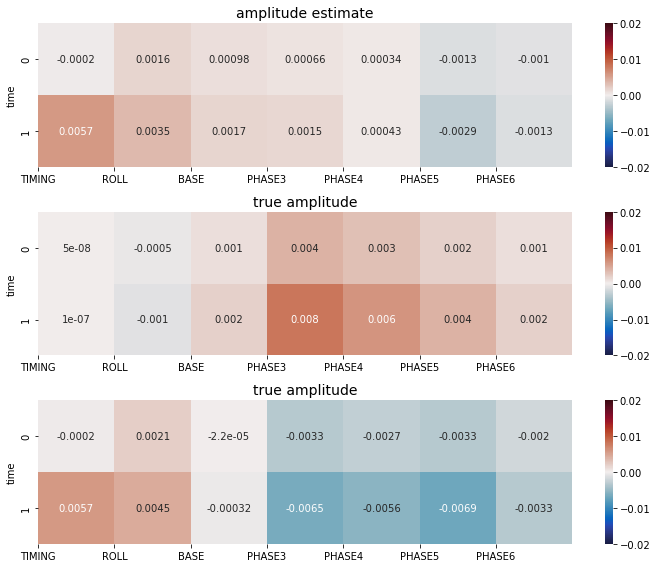

In [31]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
sns.heatmap(amp_1step[:, -7:], annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('amplitude estimate', fontsize = 14)

plt.subplot(312)
sns.heatmap(alpha, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
#plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
#plt.pcolormesh(amp_diff_1step,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
sns.heatmap(amp_diff_1step, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
plt.tight_layout()

plt.savefig('./corr_matrix.png')

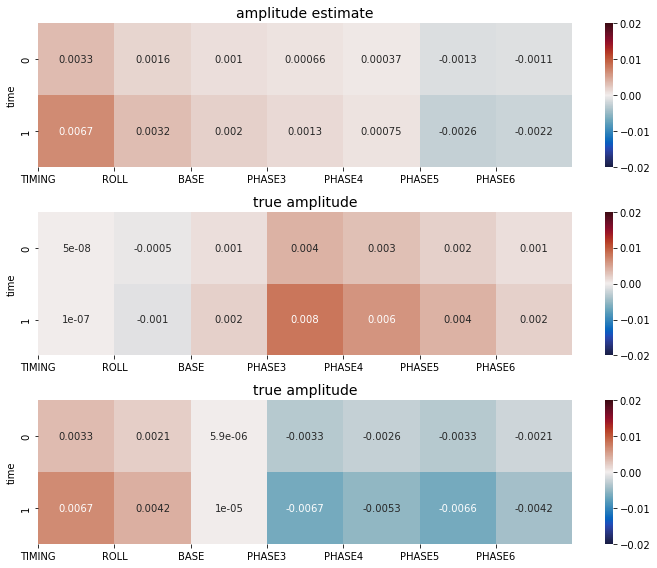

In [32]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
sns.heatmap(amp_err_only[:, -7:], annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('amplitude estimate', fontsize = 14)

plt.subplot(312)
sns.heatmap(alpha, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(4)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
#plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
#plt.pcolormesh(amp_diff_1step,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
sns.heatmap(amp_diff_err_only, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
plt.tight_layout()

#plt.savefig('./corr_matrix.png')

#### compare the training data (truth) to estimate

In [42]:
for tt in range(Tdim):
    ssh_estimated_swath[tt] = np.matmul(H_v[tt], amp_1step[tt])

In [45]:
diff_percent

array([3165.34619292,           nan])

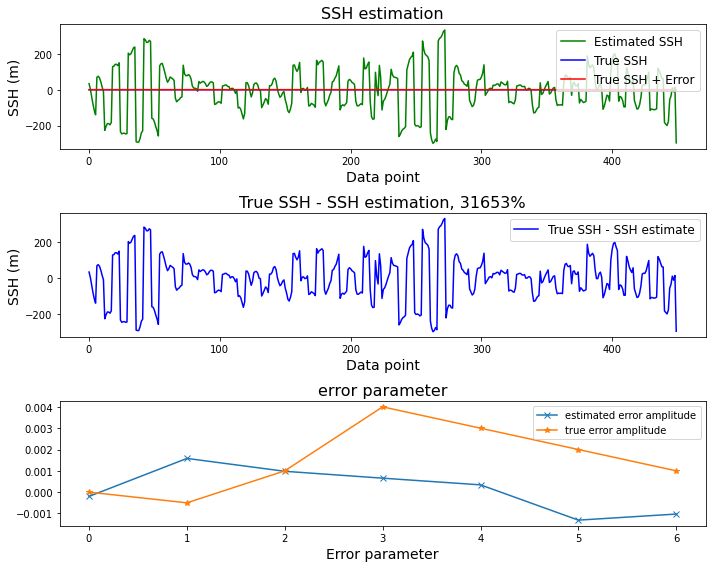

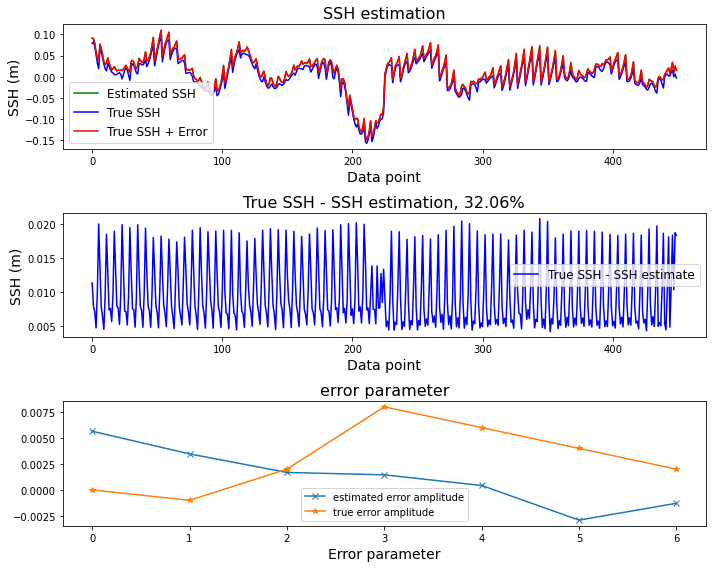

In [46]:
ssh_diff = np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    
    ssh_diff[tt] = ssh_estimated_swath[tt] - ssh[tt]
    
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(ssh_estimated_swath[tt], 'green', label='Estimated SSH')
    plt.plot(ssh[tt], 'b', label='True SSH')
    plt.plot(Y_v[tt], 'r', label = 'True SSH + Error')
    #plt.plot(np.matmul(H_v, ))
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('SSH estimation', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(312)
    #plt.plot(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()), '-', label='SSH difference')
    diff_percent[tt] = np.sqrt(ssh_diff[tt]**2).mean() / np.sqrt(ssh[tt  : (tt+1)]**2).mean()
    plt.plot(ssh_diff[tt], 'b', label='True SSH - SSH estimate')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('True SSH - SSH estimation, ' + str(diff_percent[tt] * 100)[:5] + '%', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(313)
    plt.title('error parameter', fontsize=16)
    plt.plot(amp_1step[tt, -7:], '-x', label = 'estimated error amplitude')
    plt.plot(alpha[tt], '-*', label = 'true error amplitude')
    plt.xlabel('Error parameter', fontsize=14)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('./ssh_err_estimate/ssh_err_parameter_'+  str(date_time[tt])[:10] +'.png')

In [36]:
from scipy.stats import norm
ssh_diff = ssh_estimated_swath - ssh

In [37]:
amp_1step.shape

(2, 387)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


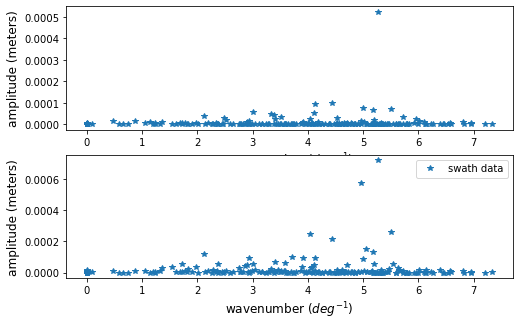

In [38]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[tt, :-7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()